# Canopy

## Initialise Canopy

### Load packages

In [1]:
%matplotlib inline
%load_ext autoreload

import os
import sys
import gdal
import pandas as pd
import numpy as np
import xarray as xr
import datacube
import matplotlib.pyplot as plt

sys.path.append('../../../Scripts')
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('../../modules')
import canopy

sys.path.append('../../shared')
import satfetcher, tools

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster

In [2]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33903 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Show study area for context

In [3]:
# testing study area extent - yandi and roy hill
lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

## Load and prepare canopy height model raster

### Set raster paths

In [4]:
# get canopy height model raster
rast_path = r'../../data/nicher/roy_lidar/chm_lidar_10m.tif'


### Load raster

In [5]:
# load rasters as individual dataset variables
ds = satfetcher.load_local_rasters(rast_path_list=rast_path, 
                                   use_dask=True, 
                                   conform_nodata_to=-999)

# show data
#ds

Converting rasters to an xarray dataset.
Converted raster to xarray data array: chm_lidar_10m
Rasters converted to dataset successfully.



### Compute raster into memory

In [6]:
# compute dask - we need to make calculations
ds = ds.compute()

### Show a subset of canopy height map

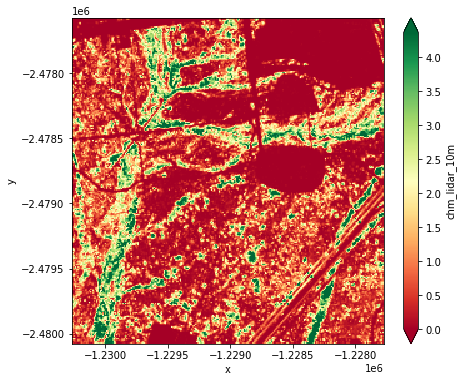

In [7]:
# set a small subset of canopy to investigate
da = ds.isel(x=slice(1000, 1250), y=slice(1000, 1250))

# plot map
fig = plt.figure(figsize=(7, 6))
da['chm_lidar_10m'].plot(robust=True, cmap='RdYlGn')

## Create binary canopy height masks

### Create a binary mask of canopy over 2m tall only

Creating binary mask from canopy height model.
Generating mask of height > 2m.


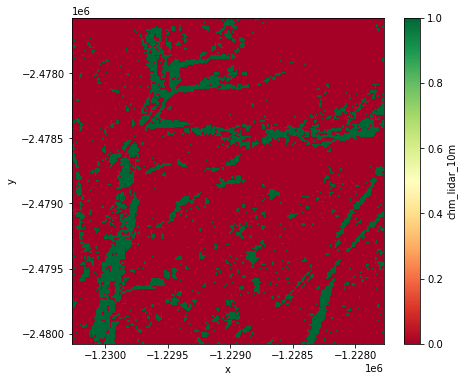

In [8]:
# create binary mask showing canopy height > than 2m
da_over_2m = canopy.binary_mask(da, remove_lt=2)

# plot binary mask
fig = plt.figure(figsize=(7, 6))
da_over_2m['chm_lidar_10m'].plot(robust=True, cmap='RdYlGn')

### Create a binary mask of canopy < 3m tall only

Creating binary mask from canopy height model.
Generating mask of height < 3m.


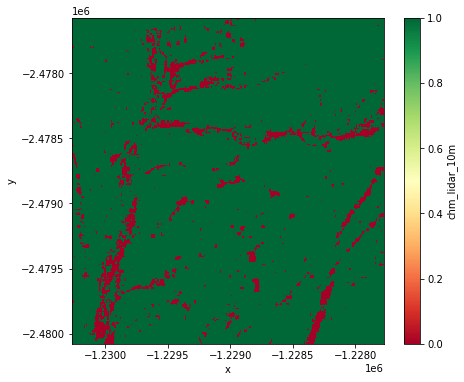

In [9]:
# create binary mask showing canopy height < than 3m
da_under_3m = canopy.binary_mask(da, remove_gt=3)

# plot binary mask
fig = plt.figure(figsize=(7, 6))
da_under_3m['chm_lidar_10m'].plot(robust=True, cmap='RdYlGn')

### Create a binary mask of canopy between 4m and 5m tall

Creating binary mask from canopy height model.
Generating mask of height between 4m and 5m.


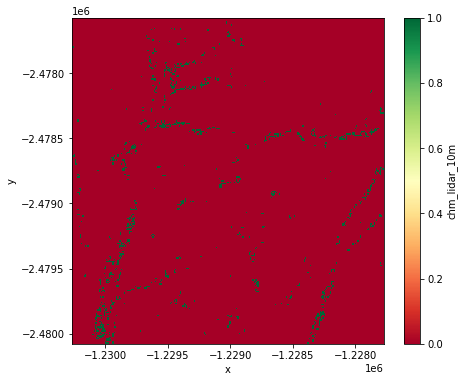

In [10]:
# create binary mask showing canopy heights between 4m and 5m
da_btwn_4m_5m = canopy.binary_mask(da, remove_lt=4, remove_gt=5)

# plot binary mask
fig = plt.figure(figsize=(7, 6))
da_btwn_4m_5m['chm_lidar_10m'].plot(robust=True, cmap='RdYlGn')

## Create fuzzy sigmoidal increasing canopy height masks

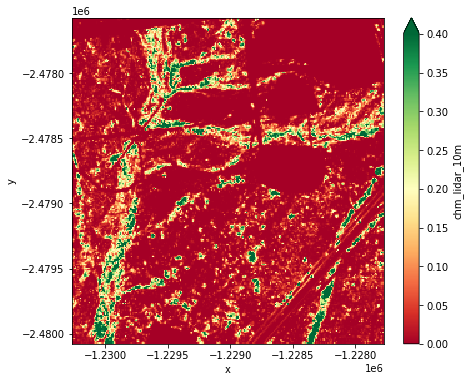

In [109]:
# perform an inc sigmoidal to rescale 0-1, cut off top end
da_inc_sig = canopy.inc_sigmoid(da, a=0, b=10)

# plot sigmoidal mask
fig = plt.figure(figsize=(7, 6))
da_inc_sig['chm_lidar_10m'].plot(robust=True, cmap='RdYlGn')

## Create fuzzy sigmoidal decreasing canopy height masks

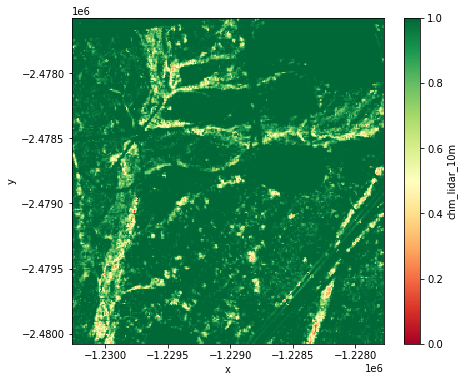

In [110]:
%autoreload

# perform an inc sigmoidal to rescale 0-1, cut off top end
da_dec_sig = canopy.dec_sigmoid(da, c=0.0001, d=10)

# plot sigmoidal mask
fig = plt.figure(figsize=(7, 6))
da_dec_sig['chm_lidar_10m'].plot(robust=False, cmap='RdYlGn')

In [ ]:
def bell_sigmoid(ds, a=None, bc=None, d=None, inplace=True):
    """
    Apply a fuzzy membership function to data
    using bell-shaped sigmoidal function. Requires a
    low left inflection (a), a mid-point (bc), and a low 
    right inflection (d) point to set the bounds in which to 
    rescale all values to. Values at or closer to the bc
    inflection point will be boosted, where as values on 
    right and left sides will be reduced. The output dataset 
    will have values rescaled to 0-1.
    
    Parameters
    ----------
    ds: xarray dataset/array
        A dataset with x, y dims.
    a : int
        Lower left slope inflection point. 
    bc : int
        Mid slope inflection point.
    d : int
        Lower right slope inflection point.

    Returns
    ----------
    ds : xarray dataset or array.
    """
    
    # checks
    if a is None or bc is None or d is None:
        raise ValueError('Parameters a, bc and d must all have a value.')
    
    if not inplace:
        ds = ds.copy(deep=True)
        
    # calc left sigmoidal
    mask_l_a = xr.where(ds > a, True, False)
    mask_l_b = xr.where(ds < bc, True, False)
    
    left = (1 - ((ds - a) / (bc - a))) * (math.pi / 2)
    left = np.cos(left)
    #left = np.square(left * xr.where(ds <= bc, 1, 0))
    left = np.square(left)
    
    #left = left.where(mask_a, 0)
    #left = left.where(mask_b, 1)
    
    # calc right sigmoidal
    mask_r_a = xr.where(ds > bc, True, False)
    mask_r_b = xr.where(ds < d, True, False)
    
    right = ((ds - bc) / (d - bc)) * (math.pi / 2)
    right = np.cos(right)
    #right = np.square(right * xr.where((ds > bc) & (ds <= d), 1, 0))
    right = np.square(right)
    
    #right = right.where(mask_a, 1)
    #right = right.where(mask_b, 0)
    
    # sum results
    ds = left + right
    
    ds = ds.where(mask_l_a, 0)
    ds = ds.where(mask_l_b, 1)
    ds = ds.where(mask_r_a, 0)
    ds = ds.where(mask_r_b, 1)

    return ds

In [ ]:
#if not inplace:
    #ds = ds.copy(deep=True)
a = 0
bc = 4
d = 13

test = bell_sigmoid(ds=ds, a=a, bc=bc, d=d)


test['chm_lidar_10m'].isel(x=slice(1000, 1250), y=slice(1000, 1250)).plot(robust=True, cmap='terrain_r')

In [ ]:
ds['chm_lidar_10m'].plot()

In [ ]:
# create left,r ight sigmoidal functions
left = np.square(np.cos((1 - ((ds_similarity - 0) / (1 - 0))) * (np.pi / 2))) 


In [ ]:
# generate left and right sigmoidals
left = np.square(np.cos((1 - ((ds_similarity - 0) / (1 - 0))) * (np.pi / 2))) 
right = np.square(np.cos(((ds_similarity - 1) / (2 - 1)) * (np.pi / 2)))

# set values to 0 depending on left or right side
left = left.where(ds_similarity <= 1, 0.0)
right = right.where(ds_similarity > 1, 0.0)

# combine left and right
ds_similarity = left + right

# mask to high veg/moist, if requested
if q_mask:

    # notify
    print('Masking similarity areas to higher vege and moist areas.')   

    # get mask where similarity greater than percentile
    mask = xr.where(ds > ds.quantile(dim=['x', 'y'], q=q_mask), True, False)

    # reduce seasons to a year, get max (true if both, true if one), rename time
    mask = mask.groupby('time.year').max('time')
    mask = mask.rename({'year': 'time'})

    # if lengths match, set mask times to match similairty, then mask
    if len(ds_similarity['time']) == len(mask['time']):
        mask['time'] = ds_similarity['time'].values
        ds_similarity = ds_similarity.where(mask, 0.0)

    else:
        print('Could not mask similarity areas. Returning full similarity.')

# drop quantile tag the method adds, if exists
ds_similarity = ds_similarity.drop('quantile', errors='ignore')